In [3]:
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
from utilis import get_dataset
import matplotlib.pyplot as plt

In [4]:
model = tf.keras.models.load_model('model_75.keras')

In [5]:
df, scale_max, scale_min = get_dataset(mode='predict', horizon=5, number_lags=75)
predicts = model.predict(tf.convert_to_tensor(df.drop('close', axis=1).values))

C:\Users\Pasha\OneDrive\Desktop\OOED\OEOD-\SUP\utilis.py:292: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  read_df[indicators.columns] = scaler_indicators.transform(indicators)
C:\Users\Pasha\OneDrive\Desktop\OOED\OEOD-\SUP\utilis.py:292: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  read_df[indicators.columns] = scaler_indicators.transform(indicators)
C:\Users\Pasha\OneDrive\Desktop\OOED\OEOD-\SUP\utilis.py:292: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

38/38 [==============================] - 2s 30ms/step


In [8]:
portfolio = pd.DataFrame()
portfolio['close'] = df['close'].apply(lambda x: x * (scale_max - scale_min) + scale_min)
portfolio['predicted_5_close'] = predicts[:, 0]
portfolio['predicted_5_close'] = portfolio['predicted_5_close'].apply(lambda x: x * (scale_max - scale_min) + scale_min)
portfolio['estimated_differece'] = portfolio['predicted_5_close'] - portfolio['close']
portfolio['q90'] = portfolio['estimated_differece'].apply(lambda x: True if x > portfolio['estimated_differece'].quantile(0.95) else False)
portfolio['q5'] = portfolio['estimated_differece'].apply(lambda x: True if x < portfolio['estimated_differece'].quantile(0.05) else False)
portfolio['returns'] = portfolio['close'].pct_change() 
portfolio = portfolio.dropna()


def calculate_percentage_change(old_value, new_value):
    if old_value == 0:
        return np.nan
    else:
        return (new_value - old_value) / old_value * 100

buy_hold = calculate_percentage_change(portfolio['close'].values[0], portfolio['close'].values[-1]) * 10000 * 0.01 + 10000

calculate_percentage_change(portfolio['close'].values[0], portfolio['close'].values[-1])


38.243469127156246

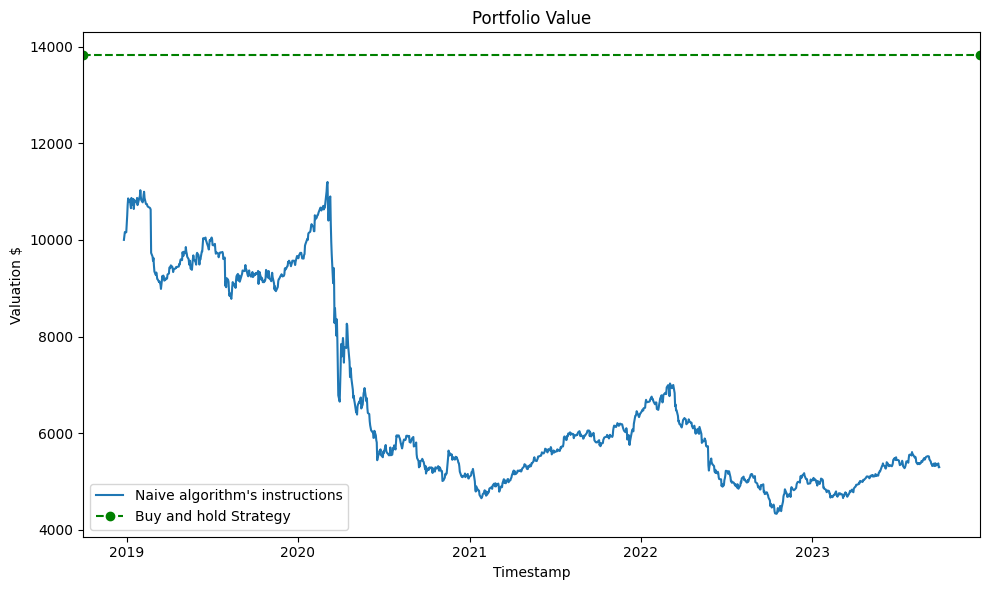

In [28]:
# Naive strategy
action = 0
portfolio_returns = portfolio['returns'].values.tolist()
for index in range(len(portfolio_returns)):
    action = 1 if portfolio['estimated_differece'].values[index] >= 0 else -1
    if index == 0: 
        portfolio_value = 10000
    else:
        portfolio_value = portfolio_returns[index-1]
    new_portfolio_value = portfolio_returns[index] * portfolio_value * action  + portfolio_value
    if portfolio_value > 0:
        portfolio_returns[index] = new_portfolio_value
    else:
        portfolio_returns[index] = 0

portfolio['naive_strategy'] = portfolio_returns
x = portfolio['naive_strategy'].index
y = portfolio['naive_strategy'].values
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="Naive algorithm's instructions")
plt.axhline(y=buy_hold, color='green', linestyle='--', marker='o', label='Buy and hold Strategy')
plt.xlabel("Timestamp")
plt.ylabel("Valuation $")
plt.title("Portfolio Value")
plt.legend()
plt.tight_layout()
plt.show()


### We will tell our trading bot to trade only when its very convinced about the certain direction, which is taken from the upper and lower quantiles from estimated price prediction

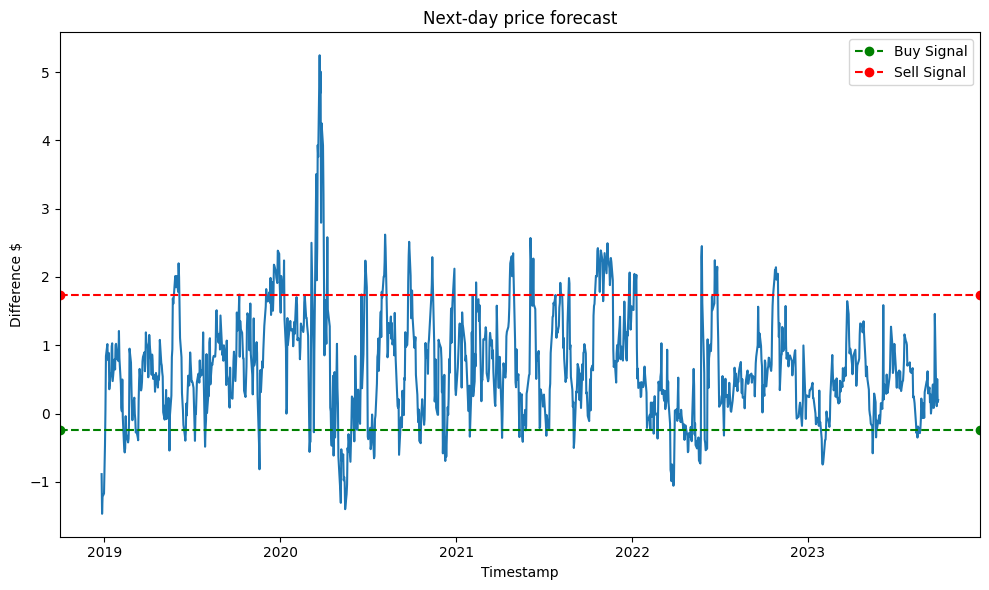

In [29]:
x = portfolio['naive_strategy'].index
y = portfolio['estimated_differece'].values
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.axhline(y=portfolio['estimated_differece'].quantile(0.1), color='green', linestyle='--', marker='o', label='Buy Signal')
plt.axhline(y=portfolio['estimated_differece'].quantile(0.9), color='red', linestyle='--', marker='o', label='Sell Signal')
plt.xlabel("Timestamp")
plt.ylabel("Difference $")
plt.title("Next-day price forecast")
plt.legend()
plt.tight_layout()
plt.show()



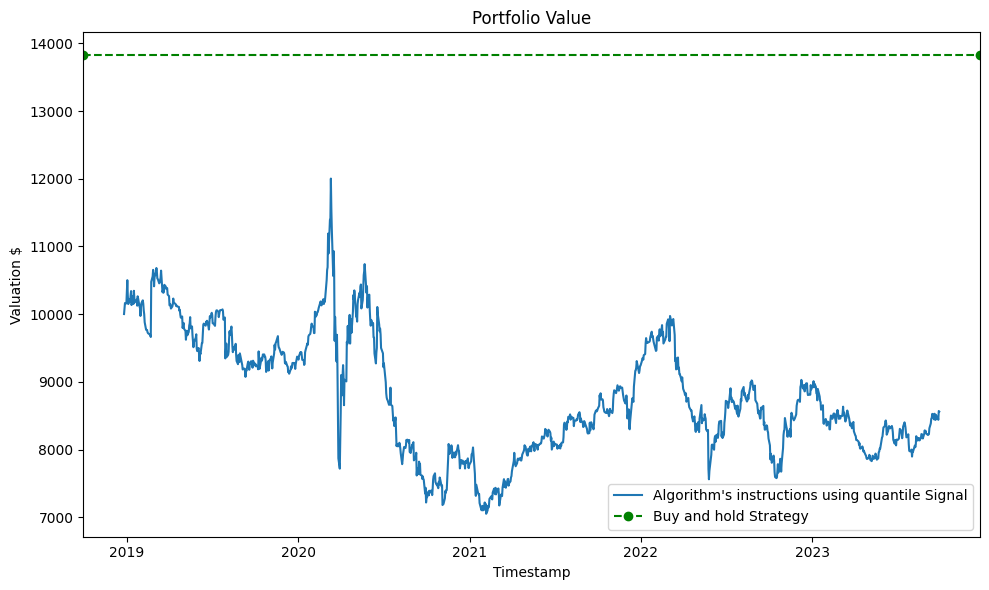

In [31]:
# Naive strategy
portfolio_returns = portfolio['returns'].values.tolist()
action = 0
for index in range(len(portfolio_returns)):
    if portfolio['q5'].values[index] == True:
        action = -1
    if portfolio['q90'].values[index] == True:
        action = 1
    if index == 0: 
        portfolio_value = 10000
    else:
        portfolio_value = portfolio_returns[index-1]
    new_portfolio_value = portfolio_returns[index] * portfolio_value * action  + portfolio_value
    if portfolio_value > 0:
        portfolio_returns[index] = new_portfolio_value
    else:
        portfolio_returns[index] = 0

portfolio['convince'] = portfolio_returns
x = portfolio['convince'].index
y = portfolio['convince'].values
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="Algorithm's instructions using quantile Signal")
plt.axhline(y=buy_hold, color='green', linestyle='--', marker='o', label='Buy and hold Strategy')
plt.xlabel("Timestamp")
plt.ylabel("Valuation $")
plt.title("Portfolio Value")
plt.legend()
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


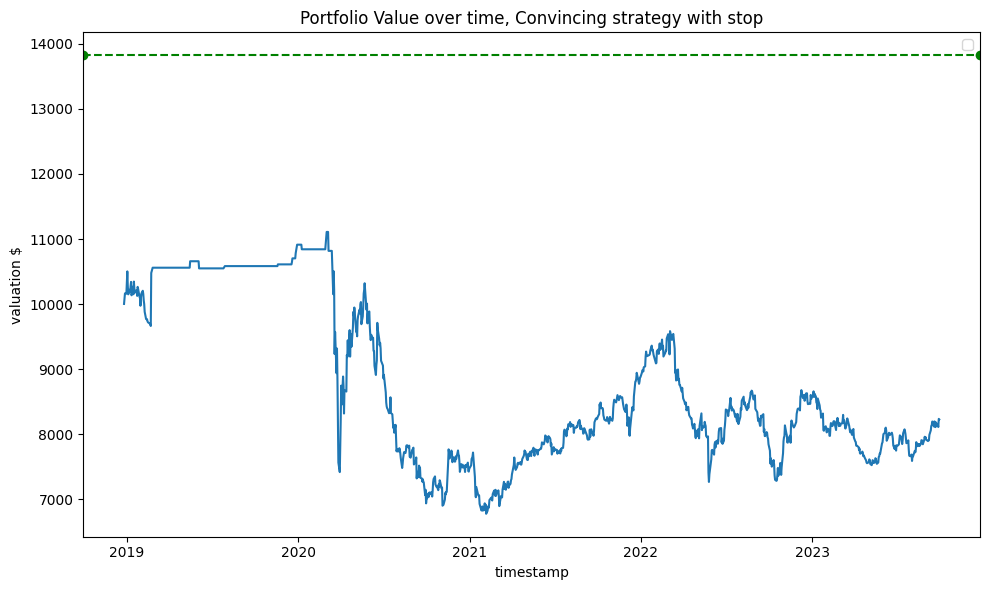

In [13]:
# Naive strategy
portfolio_returns = portfolio['returns'].values.tolist()

trailing_stop = []

action = 0
for index in range(len(portfolio_returns)):
    if portfolio['q5'].values[index] == True:
        action = -1
    if portfolio['q90'].values[index] == True:
        action = 1
    if index == 0: 
        portfolio_value = 10000
    else:
        portfolio_value = portfolio_returns[index-1]
    new_portfolio_value = portfolio_returns[index] * portfolio_value * action  + portfolio_value
    if portfolio_value > 0:
        portfolio_returns[index] = new_portfolio_value
    else:
        portfolio_returns[index] = 0
    
    trailing_stop.append(new_portfolio_value)

    trailing_stop_value = calculate_percentage_change(trailing_stop[-1], trailing_stop[0])
    if trailing_stop_value < -5:
        action = 0

    

portfolio['convince'] = portfolio_returns
x = portfolio['convince'].index
y = portfolio['convince'].values
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.axhline(y=buy_hold, color='green', linestyle='--', marker='o')
plt.xlabel("timestamp")
plt.ylabel("valuation $")
plt.title("Portfolio Value over time, Convincing strategy with stop")
plt.legend()
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


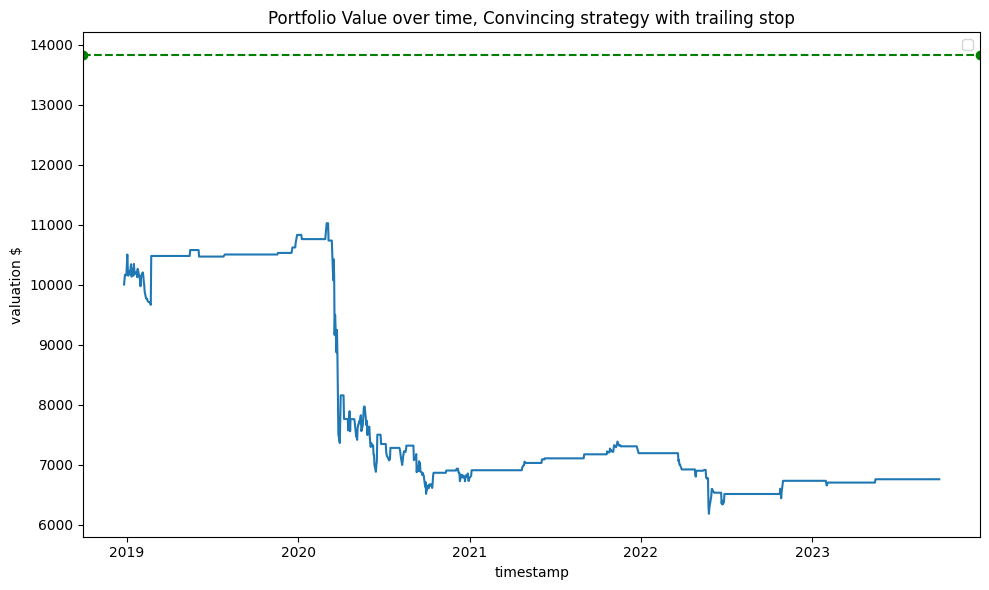

In [15]:
# Naive strategy
portfolio_returns = portfolio['returns'].values.tolist()

trailing_stop = []

action = 0
for index in range(len(portfolio_returns)):
    if portfolio['q5'].values[index] == True:
        action = -1
    if portfolio['q90'].values[index] == True:
        action = 1
    if index == 0: 
        portfolio_value = 10000
    else:
        portfolio_value = portfolio_returns[index-1]
    new_portfolio_value = portfolio_returns[index] * portfolio_value * action  + portfolio_value
    if portfolio_value > 0:
        portfolio_returns[index] = new_portfolio_value
    else:
        portfolio_returns[index] = 0
    
    trailing_stop.append(new_portfolio_value)

    for i in range(1, len(trailing_stop)+1):
        trailing_stop_value = calculate_percentage_change(trailing_stop[-1], trailing_stop[-i])
        if trailing_stop_value < -5:
            action = 0

    

portfolio['convince'] = portfolio_returns
x = portfolio['convince'].index
y = portfolio['convince'].values
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.axhline(y=buy_hold, color='green', linestyle='--', marker='o')
plt.xlabel("timestamp")
plt.ylabel("valuation $")
plt.title("Portfolio Value over time, Convincing strategy with trailing stop")
plt.legend()
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


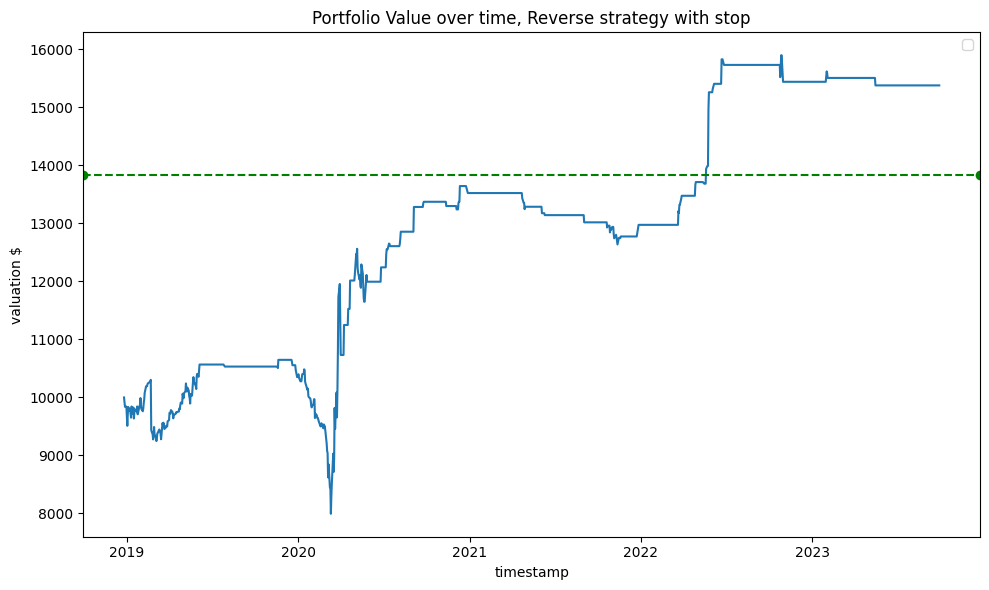

In [17]:
# Naive strategy
portfolio_returns = portfolio['returns'].values.tolist()

trailing_stop = []

action = 0
for index in range(len(portfolio_returns)):
    if portfolio['q90'].values[index] == True:
        action = -1
    if portfolio['q5'].values[index] == True:
        action = 1
    if index == 0: 
        portfolio_value = 10000
    else:
        portfolio_value = portfolio_returns[index-1]
    new_portfolio_value = portfolio_returns[index] * portfolio_value * action  + portfolio_value
    if portfolio_value > 0:
        portfolio_returns[index] = new_portfolio_value
    else:
        portfolio_returns[index] = 0
    
    trailing_stop.append(new_portfolio_value)

    trailing_stop_value = calculate_percentage_change(trailing_stop[-1], trailing_stop[0])
    if trailing_stop_value < -5:
        action = 0

    

portfolio['convince'] = portfolio_returns
x = portfolio['convince'].index
y = portfolio['convince'].values
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.axhline(y=buy_hold, color='green', linestyle='--', marker='o')
plt.xlabel("timestamp")
plt.ylabel("valuation $")
plt.title("Portfolio Value over time, Reverse strategy with stop")
plt.legend()
plt.tight_layout()
plt.show()

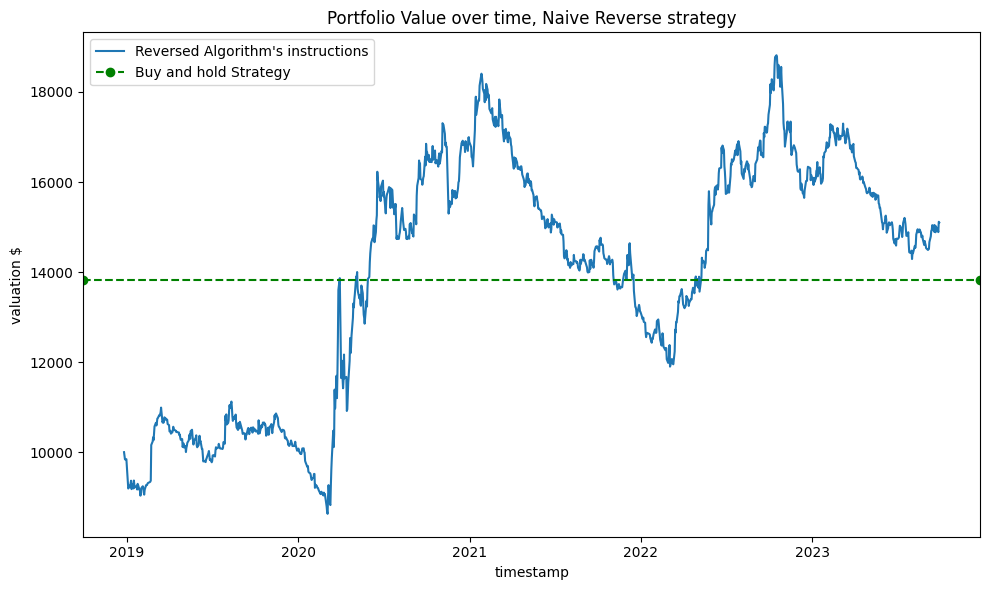

In [34]:
# Naive strategy
action = 0
portfolio_returns = portfolio['returns'].values.tolist()
for index in range(len(portfolio_returns)):
    action = -1 if portfolio['estimated_differece'].values[index] >= 0 else 1
    if index == 0: 
        portfolio_value = 10000
    else:
        portfolio_value = portfolio_returns[index-1]
    new_portfolio_value = portfolio_returns[index] * portfolio_value * action  + portfolio_value
    if portfolio_value > 0:
        portfolio_returns[index] = new_portfolio_value
    else:
        portfolio_returns[index] = 0

portfolio['naive_strategy'] = portfolio_returns
x = portfolio['naive_strategy'].index
y = portfolio['naive_strategy'].values
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="Reversed Algorithm's instructions")
plt.axhline(y=buy_hold, color='green', linestyle='--', marker='o', label='Buy and hold Strategy')
plt.xlabel("timestamp")
plt.ylabel("valuation $")
plt.title("Portfolio Value over time, Naive Reverse strategy")
plt.legend()
plt.tight_layout()
plt.show()

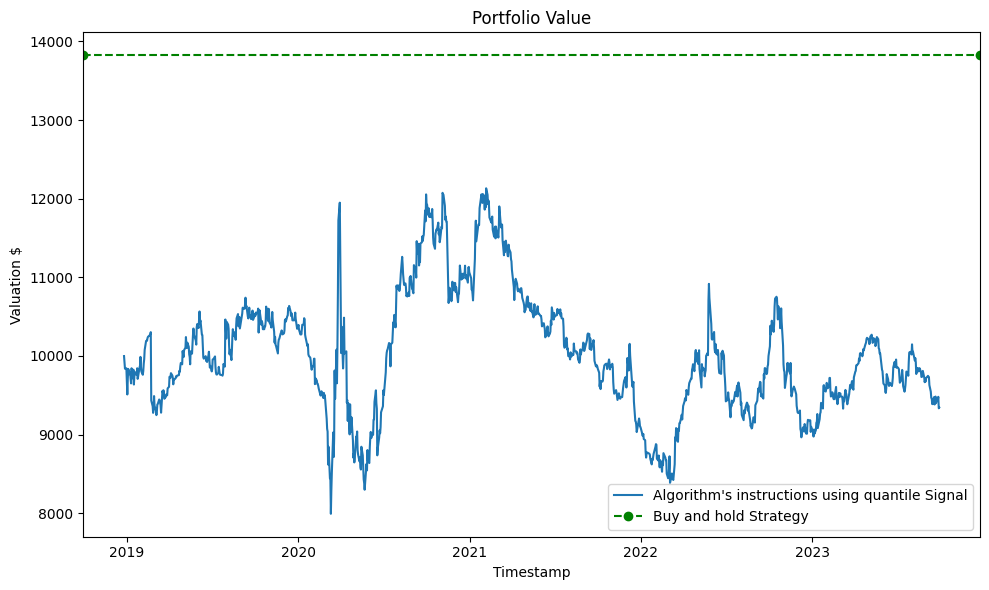

In [33]:
# Naive strategy
portfolio_returns = portfolio['returns'].values.tolist()
action = 0
for index in range(len(portfolio_returns)):
    if portfolio['q90'].values[index] == True:
        action = -1
    if portfolio['q5'].values[index] == True:
        action = 1
    if index == 0: 
        portfolio_value = 10000
    else:
        portfolio_value = portfolio_returns[index-1]
    new_portfolio_value = portfolio_returns[index] * portfolio_value * action  + portfolio_value
    if portfolio_value > 0:
        portfolio_returns[index] = new_portfolio_value
    else:
        portfolio_returns[index] = 0

portfolio['convince'] = portfolio_returns
x = portfolio['convince'].index
y = portfolio['convince'].values
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="Algorithm's instructions using quantile Signal")
plt.axhline(y=buy_hold, color='green', linestyle='--', marker='o', label='Buy and hold Strategy')
plt.xlabel("Timestamp")
plt.ylabel("Valuation $")
plt.title("Portfolio Value")
plt.legend()
plt.tight_layout()
plt.show()